In [ ]:
# default_exp ds.prediction.eval.traceability

# Empirical Methods for Software Traceability: Prediction

> This module is dedicated to evaluate word2vec/doc2vec or any neural unsupervised approaches on traceability datasets by using the theory of information transmission.
> Implementing Predictive Analysis
> Author: @danaderp Feb 2021

Software Traceability is analyzed in three classes of tasks ways: description, prediction, and causal inference. 

## Prediction. 
### Traceability Distance Predictive Analysis
In this section, we evaluate the effectiveness of traceability techniques. We employ metrics based on accuracy to evaluate the supervised software retrieval:
 - [1] Compute the average precision score and Compute ROC Curve
 - [2] Precision-Racall-Gain

### Information Tranmission Predictive Analysis
In this section, we evaluate the correlation between software transmission metrics and traceability distance metrics. 



In [1]:
from prg import prg

In [2]:
import ds4se as ds
from ds4se.mining.ir import VectorizationType
from ds4se.mining.ir import SimilarityMetric
from ds4se.mining.ir import EntropyMetric

In [3]:
#Description importation
from ds4se.ds.description.eval.traceability import VectorEvaluation

In [23]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
import gensim
import pandas as pd
from itertools import product 
from random import sample 
import functools 
import os
from enum import Enum, unique, auto

In [6]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import auc
import math as m
import random as r
import collections
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

In [7]:
from scipy.spatial import distance
from scipy.stats import pearsonr

In [8]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [9]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

## Loading Experiments

In [10]:
#experiment 0.0.0/1
experiment = 'experiments0.0.x/'
path_data = '../dvc-ds4se/metrics/traceability/' + experiment 
def libest_params():
    return{
        "system": 'libest',
        "experiment_path_w2v": path_data + '[libest-VectorizationType.word2vec-LinkType.req2tc-True-1609292406.653621].csv',
        "experiment_path_d2v": path_data + '[libest-VectorizationType.doc2vec-LinkType.req2tc-True-1609289141.142806].csv',
        'saving_path': '../dvc-ds4se/se-benchmarking/traceability/testbeds/processed/',
        'system_long': 'libest',
        'timestamp': 1596063103.098236,
        'language': 'all-corpus'
    } 

In [11]:
params = libest_params()
#params = sacp_params()

params['experiment_path_w2v']

'../dvc-ds4se/metrics/traceability/experiments0.0.x/[libest-VectorizationType.word2vec-LinkType.req2tc-True-1609292406.653621].csv'

In [12]:
%matplotlib inline

#  Data Science Prediction Task
Prediction is using data to map some features of the world (the inputs) to other features of the world (the outputs). Prediction often starts with simple tasks (e.g., quantifying the association between albumin levels at admission and death within one week among patients in the intensive care unit) and then progresses to more complex ones (e.g., using hundreds of variables measured at admission to predict which patients are more likely to die within one week). The analytics employed for prediction range from elementary calculations (e.g., a correlation coefficient or a risk difference) to sophisticated pattern recognition methods and supervised learning algorithms that can be used as classifiers (e.g., random forests, neural networks) or to predict the joint distribution of multiple variables

In [13]:
#export
class SupervisedVectorEvaluation(VectorEvaluation):

    def __init__(self, params):
        super().__init__(params)
        
        #Word2vec
        similarities_w2v = self.sim_list_w2v + ['Linked?']
        similarities_w2v = [str(i) for i in similarities_w2v]
        self.df_filtered_w2v = self.df_w2v.copy()
        self.df_filtered_w2v = self.df_filtered_w2v[similarities_w2v] 
        self.df_filtered_w2v = self.df_filtered_w2v[~self.df_filtered_w2v.isin([np.nan, np.inf, -np.inf]).any(1)]
        
        #Doc2vec
        similarities_d2v = self.sim_list_d2v + ['Linked?']
        similarities_d2v = [str(i) for i in similarities_d2v]
        self.df_filtered_d2v = self.df_d2v.copy() 
        self.df_filtered_d2v = self.df_filtered_d2v[similarities_d2v]
        self.df_filtered_d2v = self.df_filtered_d2v[~self.df_filtered_d2v.isin([np.nan, np.inf, -np.inf]).any(1)]

        pass
    
    def vecTypeVerification(self, vecType= VectorizationType.word2vec):
        if vecType == VectorizationType.word2vec:
            self.sim_list = self.sim_list_w2v
            y_test = self.df_filtered_w2v['Linked?'].values
            y_score = [self.df_filtered_w2v[ str(sim) ].values for sim in self.sim_list]
            logging.info('Vectorization: ' +  str(vecType) )
        elif vecType == VectorizationType.doc2vec:
            self.sim_list = self.sim_list_d2v
            y_test = self.df_filtered_d2v['Linked?'].values
            y_score = [self.df_filtered_d2v[ str(sim) ].values for sim in self.sim_list]
            logging.info('Vectorization: ' +  str(vecType) )
        return y_test,y_score
    
    def Compute_precision_recall_gain(self, vecType = VectorizationType.word2vec):
        '''One might choose PRG if there is little interest in identifying false negatives '''
        y_test,y_score = self.vecTypeVerification(vecType=vecType)    
        
        for count,sim in enumerate(self.sim_list):
            prg_curve = prg.create_prg_curve(y_test, y_score[count])
            auprg = prg.calc_auprg(prg_curve)
            prg.plot_prg(prg_curve)
            logging.info('auprg:  %.3f' %  auprg)
            logging.info("compute_precision_recall_gain Complete: "+str(sim))
        pass
    
    def Compute_avg_precision(self, vecType = VectorizationType.word2vec):
        '''Generated precision-recall curve enhanced'''
        y_test,y_score = self.vecTypeVerification(vecType=vecType)
        
        linestyles = ['solid','dashed','dashdot','dotted']
        
        fig, ax1 = plt.subplots(figsize=(8, 6))
        
        ax1.grid(True)
        #ax1.yaxis.grid(color='gray', linestyle='dashed')
        
        color = 'tab:red'
        ax1.set_xlabel('recall [fpr]')
        ax1.set_ylabel('precision', color=color)
        
        # calculate the no skill line as the proportion of the positive class
        no_skill = len(y_test[y_test==1]) / len(y_test)
        ax1.plot([0, 1], [no_skill, no_skill], color=color, linewidth=0.5, linestyle='dotted', label='No Skill [{0:0.2f}]'.format(no_skill)) #reference curve
        
        for count,sim in enumerate(self.sim_list):
            precision, recall, _ = precision_recall_curve(y_test, y_score[count]) #compute precision-recall curve
            average_precision = average_precision_score(y_test, y_score[count])
            auc_score = auc(recall, precision)
            logging.info('Average precision-recall score: {0:0.2f}'.format(average_precision))
            logging.info('Precision-Recall AUC: %.2f' % auc_score)
            
            #plt.plot(recall, precision, linewidth=0.4, marker='.', label = str(sim)) #plot model curve
            ax1.plot(recall, precision, color=color, linewidth=1, linestyle=linestyles[count], label = str(sim.name)+' [auc:{0:0.2f}]'.format(auc_score)) #plot model curve
            
            pass     
        
        ax1.tick_params(axis='y', labelcolor=color) #Color of the axis value
        
        
        ##AUC
        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
        
        color = 'tab:blue'
        ax2.set_ylabel('tpr', color=color)  # we already handled the x-label with ax1
        
        ax2.plot([0, 1], [0, 1], color=color,  linewidth=0.5, linestyle='dotted', label='No Skill') #reference curve
        for count,sim in enumerate(self.sim_list):
            fpr, tpr, _ = roc_curve(y_test, y_score[count]) #compute roc curve
            roc_auc = roc_auc_score(y_test, y_score[count])
            logging.info('ROC AUC %.2f' % roc_auc)
            
            ax2.plot(fpr, tpr, color=color, linewidth=1, linestyle=linestyles[count], label = str(sim.name)+ ' [auc:{0:0.2f}]'.format(roc_auc)) #plot model curve
            pass   
        
        ax2.tick_params(axis='y', labelcolor=color) #Color of the axis value
        
        ##Design
        ax1.legend(loc='upper center',ncol=3, fontsize= 'small')
        ax2.legend(loc='lower center',ncol=3, fontsize= 'small')
        
        fig.tight_layout()  # otherwise the right y-label is slightly clipped
        
        #plt.set_axisbelow(True)
        #plt.yaxis.grid(color='gray', linestyle='dashed')
        
        plt.title( params['system'] + "-[" + str(vecType) + "]")
        plt.show() #show the plot
        pass
    
    def __Compute_avg_precision_same_plot(self, vecType = VectorizationType.word2vec):
        '''Generated precision-recall curve'''

        y_test,y_score = self.vecTypeVerification(vecType=vecType)
        
        # calculate the no skill line as the proportion of the positive class
        no_skill = len(y_test[y_test==1]) / len(y_test)
        plt.plot([0, 1], [no_skill, no_skill], linewidth=0.5, linestyle='--', label='No Skill [{0:0.2f}]'.format(no_skill)) #reference curve
        
        for count,sim in enumerate(self.sim_list):
            precision, recall, _ = precision_recall_curve(y_test, y_score[count]) #compute precision-recall curve
            average_precision = average_precision_score(y_test, y_score[count])
            auc_score = auc(recall, precision)
            logging.info('Average precision-recall score: {0:0.2f}'.format(average_precision))
            logging.info('Precision-Recall AUC: %.2f' % auc_score)
            
            #plt.plot(recall, precision, linewidth=0.4, marker='.', label = str(sim)) #plot model curve
            plt.plot(recall, precision, linewidth=1, label = str(sim)+ ' [auc:{0:0.2f}]'.format(auc_score)) #plot model curve
            pass
        
        plt.title(str(vecType))
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend(fontsize=9) #show the legend
        plt.show() #show the plot
        pass
    
    def __Compute_roc_curve(self, vecType = VectorizationType.word2vec):
        
        y_test,y_score = self.vecTypeVerification(vecType = vecType)

        plt.plot([0, 1], [0, 1],  linewidth=0.5, linestyle='--', label='No Skill') #reference curve
        
        for count,sim in enumerate(self.sim_list):
            fpr, tpr, _ = roc_curve(y_test, y_score[count]) #compute roc curve
            roc_auc = roc_auc_score(y_test, y_score[count])
            logging.info('ROC AUC %.2f' % roc_auc)
            
            plt.plot(fpr, tpr,  linewidth=1, label = str(sim)+  ' [auc:{0:0.2f}]'.format(roc_auc)) #plot model curve
            pass
        plt.title(str(vecType))
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(fontsize=9) #show the legend
        plt.show() #show the plot

        pass
    
    def CofusionMatrix(self, vecType = VectorizationType.word2vec):
        ##TODO This implementatin is incomplete and not verify it yet
        y_test,y_score = self.vecTypeVerification(vecType=vecType)
        y_score_threshold = [0 if elem<=0.8 else 1 for elem in supevisedEval.y_score] #Hardcoded 0.7 Threshold
        #TODO a Variation threshold analysis
        tn, fp, fn, tp = confusion_matrix(supevisedEval.y_test, y_score_threshold).ravel()
        return tn, fp, fn, tp

In [14]:
supevisedEval = SupervisedVectorEvaluation(params = params) #<---- Parameter 

In [15]:
#tst
supevisedEval.df_w2v.head(2)

,Source,Target,DistanceMetric.WMD,SimilarityMetric.WMD_sim,DistanceMetric.SCM,SimilarityMetric.SCM_sim,EntropyMetric.MSI_I,EntropyMetric.MSI_X,EntropyMetric.Entropy_src,EntropyMetric.Entropy_tgt,EntropyMetric.JI,EntropyMetric.MI,EntropyMetric.Loss,EntropyMetric.Noise,Linked?
0,test_data/LibEST_semeru_format/requirements/RQ...,test_data/LibEST_semeru_format/test/us903.c,0.986586,0.503376,0.611706,0.388294,4.464656,1.390740,6.024675,8.626714,8.716142,5.935246,2.691468,0.089428,0.0
1,test_data/LibEST_semeru_format/requirements/RQ...,test_data/LibEST_semeru_format/test/us3496.c,0.990643,0.502350,0.642187,0.357813,4.228282,1.385062,6.024675,7.287890,7.522528,5.790037,1.497854,0.234638,0.0


In [16]:
#tst
supevisedEval.df_d2v.head(2)

,Source,Target,DistanceMetric.EUC,SimilarityMetric.EUC_sim,DistanceMetric.COS,SimilarityMetric.COS_sim,DistanceMetric.MAN,SimilarityMetric.MAN_sim,SimilarityMetric.Pearson,Linked?
0,test_data/LibEST_semeru_format/requirements/RQ...,test_data/LibEST_semeru_format/test/us903.c,79.313499,0.012451,0.684047,0.315953,1422.18042,0.000703,0.315946,0.0
1,test_data/LibEST_semeru_format/requirements/RQ...,test_data/LibEST_semeru_format/test/us3496.c,81.898087,0.012063,0.752670,0.247330,1464.70813,0.000682,0.247231,0.0


In [17]:
#tst
supevisedEval.df_filtered_w2v.size

3276

In [18]:
#tst
supevisedEval.df_w2v.size

16380

In [19]:
#tst
supevisedEval.df_w2v[ 'Linked?' ].values

array([0., 0., 0., ..., 0., 1., 1.])

In [20]:
y_test,y_score = supevisedEval.vecTypeVerification(VectorizationType.word2vec) #tst

2021-02-13 00:55:44,926 : INFO : Vectorization: VectorizationType.word2vec


In [21]:
y_test,y_score = supevisedEval.vecTypeVerification(VectorizationType.doc2vec) #tst

2021-02-13 00:55:53,401 : INFO : Vectorization: VectorizationType.doc2vec


## Traceability Distance Predictive Analysis

### 1. Compute the average precision score and Compute ROC Curve
Precision is a metric that quantifies the number of correct positive predictions made.

Recall is a metric that quantifies the number of correct positive predictions made out of all positive predictions that could have been made.

An ROC curve (or receiver operating characteristic curve) is a plot that summarizes the performance of a binary classification model on the positive class [(see Blog)](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-imbalanced-classification/).

Use ROC when both classes detection is equally important — When we want to give equal weight to both classes prediction ability we should look at the ROC curve [link](https://towardsdatascience.com/what-metrics-should-we-use-on-imbalanced-data-set-precision-recall-roc-e2e79252aeba).

2021-02-13 00:58:58,409 : INFO : Vectorization: VectorizationType.word2vec
2021-02-13 00:58:58,438 : INFO : Average precision-recall score: 0.39
2021-02-13 00:58:58,439 : INFO : Precision-Recall AUC: 0.38
2021-02-13 00:58:58,447 : INFO : Average precision-recall score: 0.42
2021-02-13 00:58:58,448 : INFO : Precision-Recall AUC: 0.42
2021-02-13 00:58:58,473 : INFO : ROC AUC 0.57
2021-02-13 00:58:58,478 : INFO : ROC AUC 0.60


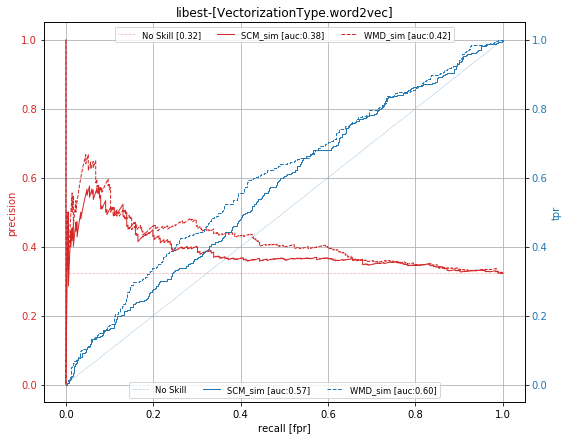

In [24]:
supevisedEval.Compute_avg_precision(VectorizationType.word2vec)

2021-02-13 00:59:23,835 : INFO : Vectorization: VectorizationType.doc2vec
2021-02-13 00:59:23,859 : INFO : Average precision-recall score: 0.33
2021-02-13 00:59:23,859 : INFO : Precision-Recall AUC: 0.33
2021-02-13 00:59:23,866 : INFO : Average precision-recall score: 0.28
2021-02-13 00:59:23,867 : INFO : Precision-Recall AUC: 0.28
2021-02-13 00:59:23,893 : INFO : ROC AUC 0.51
2021-02-13 00:59:23,899 : INFO : ROC AUC 0.42


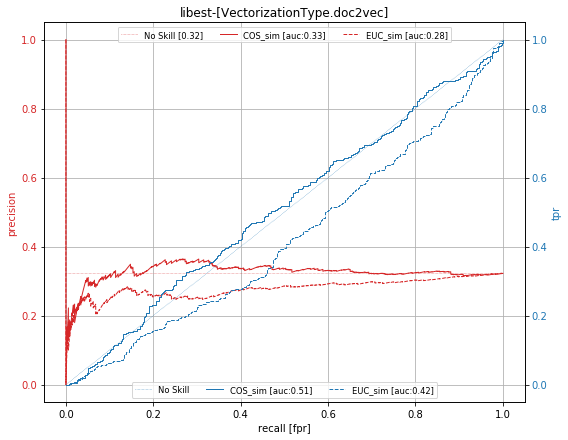

In [25]:
supevisedEval.Compute_avg_precision(VectorizationType.doc2vec)

### 2. Precision-Racall-Gain
Based on the library here: [link](https://github.com/meeliskull/prg/tree/master/Python_package). 
The area under traditional PR curves can easily favour models with lower expected F1 score than others, and so the use of Precision-Recall-Gain curves will result in better model selection [(Flach & Kull, 2015)](http://people.cs.bris.ac.uk/~flach//PRGcurves/).
One might choose PRG if there is little interest in identifying false negatives [(from Blog)](https://medium.com/@alexabate/i-did-something-boring-so-you-dont-have-to-9140ca46c84d).

2021-02-13 01:00:51,612 : INFO : Vectorization: VectorizationType.word2vec


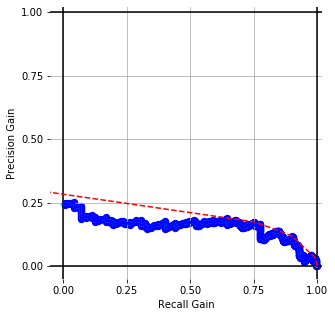

2021-02-13 01:00:51,771 : INFO : auprg:  0.156
2021-02-13 01:00:51,772 : INFO : compute_precision_recall_gain Complete: SimilarityMetric.SCM_sim


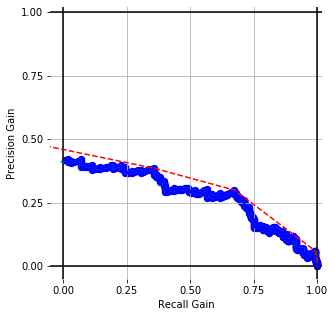

2021-02-13 01:00:51,921 : INFO : auprg:  0.278
2021-02-13 01:00:51,921 : INFO : compute_precision_recall_gain Complete: SimilarityMetric.WMD_sim


In [26]:
supevisedEval.Compute_precision_recall_gain(VectorizationType.word2vec)

2021-02-13 01:01:13,660 : INFO : Vectorization: VectorizationType.doc2vec


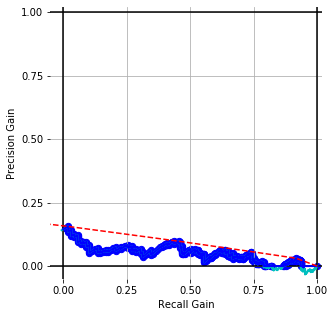

2021-02-13 01:01:13,818 : INFO : auprg:  0.050
2021-02-13 01:01:13,819 : INFO : compute_precision_recall_gain Complete: SimilarityMetric.COS_sim


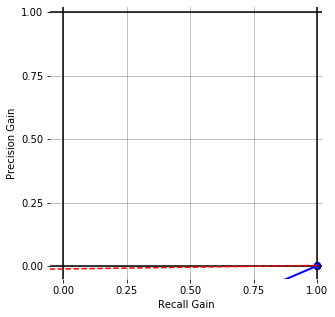

2021-02-13 01:01:13,961 : INFO : auprg:  -0.213
2021-02-13 01:01:13,962 : INFO : compute_precision_recall_gain Complete: SimilarityMetric.EUC_sim


In [27]:
supevisedEval.Compute_precision_recall_gain(VectorizationType.doc2vec)

In [ ]:
SimilarityMetric.WMD_sim.name #tst

## Information Tranmission Predictive Analysis

### Manifold Entropy Plots

In [30]:
#export
class ManifoldEntropy(VectorEvaluation):
    def __init__(self, params):
        super().__init__(params)
        self.sharedEntropy_filtered = self.sharedInfo.copy()
        self.sharedEntropy_filtered.dropna(inplace=True)
        pass
    
    def minimum_shared_entropy(self,dist = SimilarityMetric.WMD_sim, extropy=False):
        '''Minimum Shared Plot'''
        ent = EntropyMetric.MSI_I
        color = 'DarkBlue'
        if extropy:
            ent = EntropyMetric.MSI_X
            color = 'Red'
        columns = [str(i) for i in [ent, dist ]]
        
        x1 = self.sharedEntropy_filtered.plot.scatter(
            x = columns[0],
            y = columns[1], 
            c = color, 
            s = 1,
            title = params['system']+': ['+ dist.name + '-' + ent.name + '] Correlation {%.2f}' % self.compute_spearman_corr(
                self.sharedEntropy_filtered, columns)
        )
        pass
    
    def manifold_entropy_plot(self, manifold = EntropyMetric.MI, dist = SimilarityMetric.WMD_sim):
        '''Manifold Entropy'''
        
        columns = [str(i) for i in [manifold, dist]]
        
        x1 = self.manifoldEntropy.plot.scatter(
            x = columns[0],
            y = columns[1], 
            c = 'DarkBlue', 
            s = 1,
            title = params['system']+': ['+ dist.name + '-' + manifold.name + '] Correlation {%.2f}' % self.compute_spearman_corr(
                self.manifoldEntropy, columns)
        )
        pass
    
    def composable_entropy_plot(self, 
                                manifold_x = EntropyMetric.MI,
                                manifold_y = EntropyMetric.Loss,
                                dist = SimilarityMetric.WMD_sim 
                               ):
    
        columns = [str(i) for i in [manifold_x, manifold_y, dist]]
        fig, ax = plt.subplots()
        self.manifoldEntropy.plot.scatter(
            x = columns[0],
            y = columns[1],
            c = columns[2],
            #figsize = [12, 6],
            title = params['system']+': Information-Semantic Interactions '+ dist.name ,
            colormap = 'viridis',
            ax = ax,
            s=1
        )
        ax.set_xlabel( columns[0] )
        ax.set_ylabel( columns[1] )    
        pass
    
    def compute_spearman_corr(self, filter_metrics_01, columns):
        df_correlation = filter_metrics_01.copy() 
        correlation = df_correlation[columns].corr(method='spearman')
        #correlation = df_correlation.corr(method='spearman')
        return correlation[columns[0]].values[1]

In [31]:
manifoldEntropy = ManifoldEntropy(params = params) 

### Minimum Shared Entropy and Distances

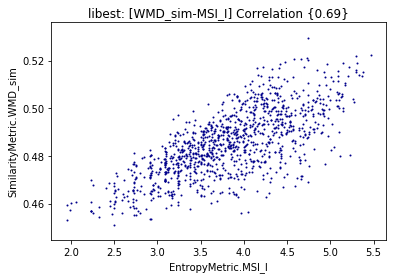

In [33]:
manifoldEntropy.minimum_shared_entropy(dist=SimilarityMetric.WMD_sim)

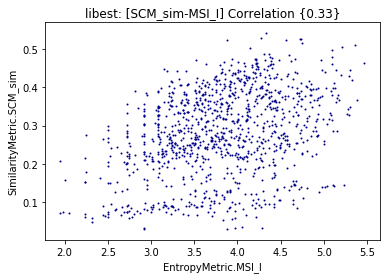

In [34]:
manifoldEntropy.minimum_shared_entropy(dist=SimilarityMetric.SCM_sim)

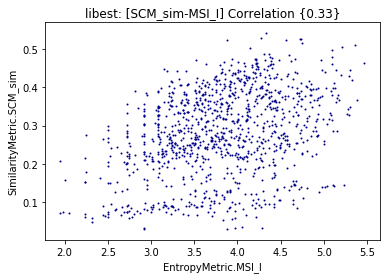

In [35]:
manifoldEntropy.minimum_shared_entropy(dist=SimilarityMetric.SCM_sim)

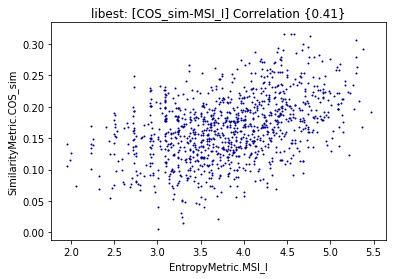

In [36]:
manifoldEntropy.minimum_shared_entropy(dist=SimilarityMetric.COS_sim)

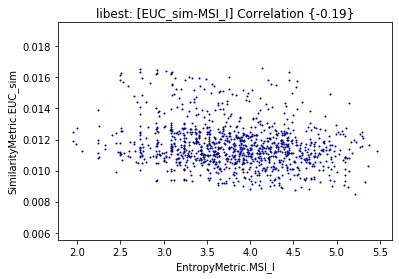

In [37]:
manifoldEntropy.minimum_shared_entropy(dist=SimilarityMetric.EUC_sim)

### Minimum Shared Extropy and Distances

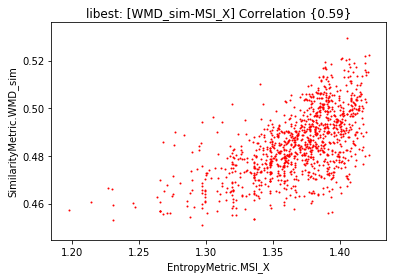

In [38]:
manifoldEntropy.minimum_shared_entropy(dist=SimilarityMetric.WMD_sim, extropy=True)

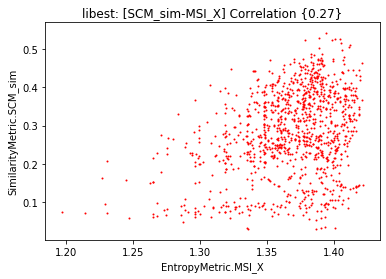

In [39]:
manifoldEntropy.minimum_shared_entropy(dist=SimilarityMetric.SCM_sim, extropy=True)

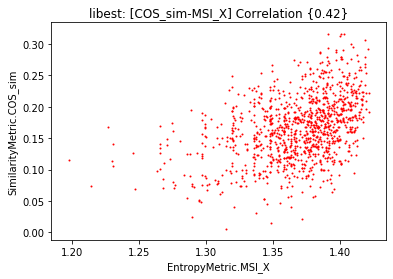

In [40]:
manifoldEntropy.minimum_shared_entropy(dist=SimilarityMetric.COS_sim, extropy=True)

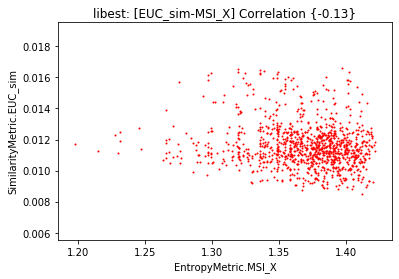

In [41]:
manifoldEntropy.minimum_shared_entropy(dist=SimilarityMetric.EUC_sim, extropy=True)

### Mutual Information and Distance

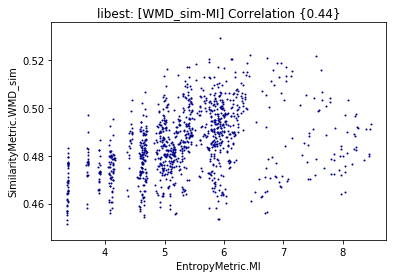

In [42]:
manifoldEntropy.manifold_entropy_plot(manifold = EntropyMetric.MI, dist = SimilarityMetric.WMD_sim)

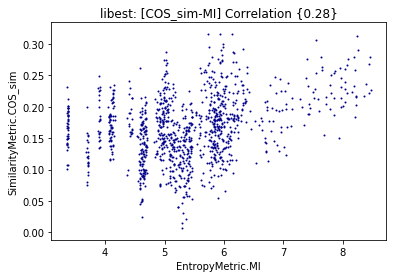

In [43]:
manifoldEntropy.manifold_entropy_plot(manifold = EntropyMetric.MI, dist = SimilarityMetric.COS_sim)

### Loss Information and Distance

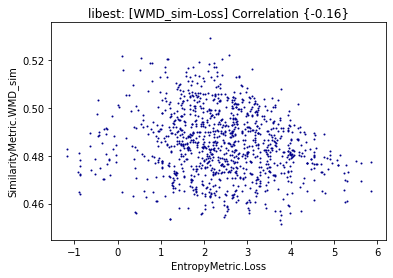

In [44]:
manifoldEntropy.manifold_entropy_plot(manifold = EntropyMetric.Loss, dist = SimilarityMetric.WMD_sim)

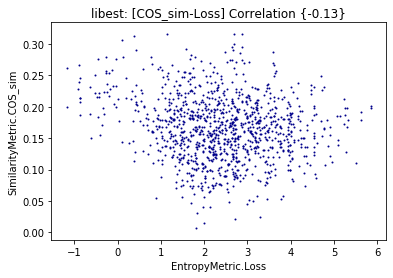

In [45]:
manifoldEntropy.manifold_entropy_plot(manifold = EntropyMetric.Loss, dist = SimilarityMetric.COS_sim)

### Noise Information and Distance

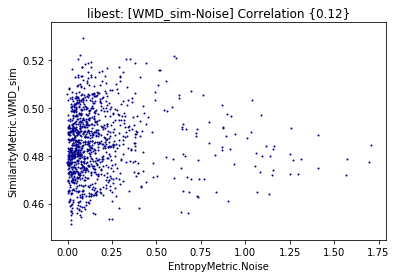

In [46]:
manifoldEntropy.manifold_entropy_plot(manifold = EntropyMetric.Noise, dist = SimilarityMetric.WMD_sim)

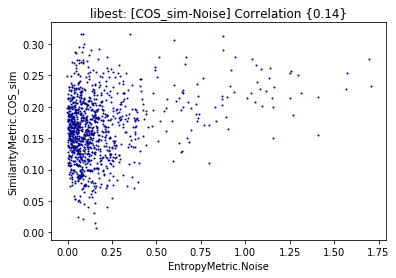

In [47]:
manifoldEntropy.manifold_entropy_plot(manifold = EntropyMetric.Noise, dist = SimilarityMetric.COS_sim)

### Self-Information

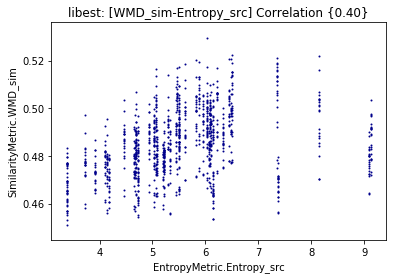

In [48]:
manifoldEntropy.manifold_entropy_plot(manifold = EntropyMetric.Entropy_src, dist = SimilarityMetric.WMD_sim)

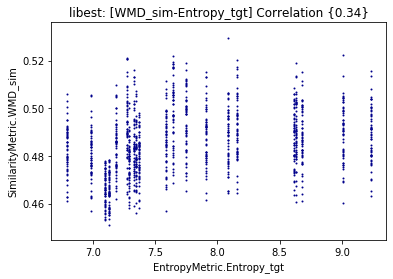

In [49]:
manifoldEntropy.manifold_entropy_plot(manifold = EntropyMetric.Entropy_tgt, dist = SimilarityMetric.WMD_sim)

## Composable Manifolds

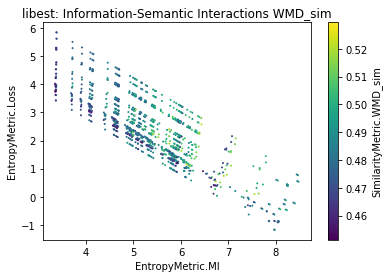

In [51]:
manifoldEntropy.composable_entropy_plot(
                        manifold_x = EntropyMetric.MI,
                        manifold_y = EntropyMetric.Loss,
                        dist = SimilarityMetric.WMD_sim )

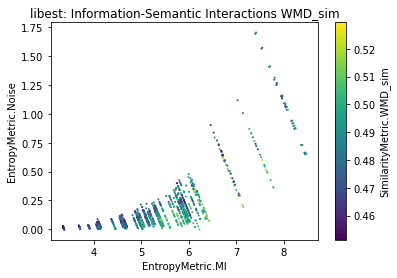

In [52]:
manifoldEntropy.composable_entropy_plot(
                        manifold_x = EntropyMetric.MI,
                        manifold_y = EntropyMetric.Noise,
                        dist = SimilarityMetric.WMD_sim )

### Grouping Mutual information & Similarity Thru Noise

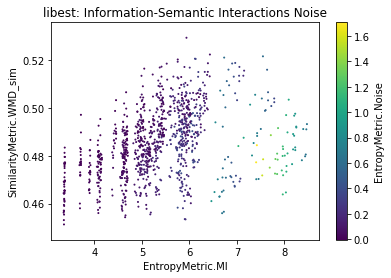

In [53]:
manifoldEntropy.composable_entropy_plot(
                        manifold_x = EntropyMetric.MI,
                        manifold_y = SimilarityMetric.WMD_sim,
                        dist = EntropyMetric.Noise )

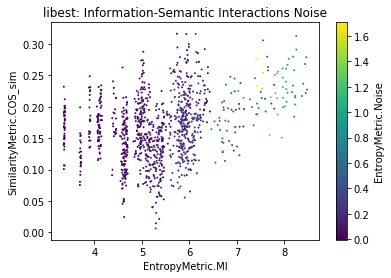

In [54]:
manifoldEntropy.composable_entropy_plot(
                        manifold_x = EntropyMetric.MI,
                        manifold_y = SimilarityMetric.COS_sim,
                        dist = EntropyMetric.Noise )

### Grouping Mutual information & Similarity Thru Loss

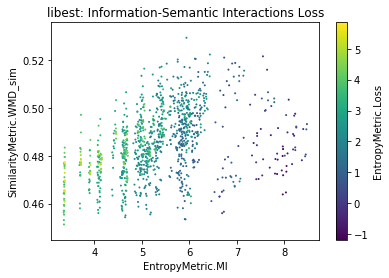

In [55]:
manifoldEntropy.composable_entropy_plot(
                        manifold_x = EntropyMetric.MI,
                        manifold_y = SimilarityMetric.WMD_sim,
                        dist = EntropyMetric.Loss )

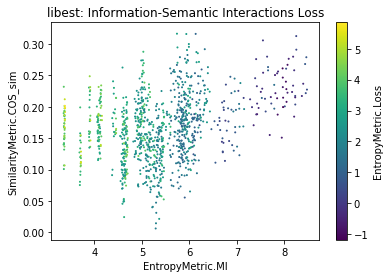

In [56]:
manifoldEntropy.composable_entropy_plot(
                        manifold_x = EntropyMetric.MI,
                        manifold_y = SimilarityMetric.COS_sim,
                        dist = EntropyMetric.Loss )

### Deployment

In [ ]:
! nbdev_build_docs #<-------- [Activate when stable]

In [ ]:
! nbdev_build_lib

In [ ]:
from nbdev.export import notebook2script
notebook2script()

In [57]:
#! pip install -e .